(reactions)=
# Reactions

In FESTIM, chemical reactions between species are defined (in the bulk) with ``Reaction`` objects.

We will learn in this tutorial how these can be used a building blocks for many different problems.

**Objectives**

- Define simple chemical reactions
- Understand how trapping can be defined as a reaction
- Define more complex reaction scheme (multi-occupancy trapping, decay, etc.)

## Simple reaction

We'll start with a simple reaction between species A and B forming species C at a rate $k$ and assume there is no backward reaction.

```{math}
\ce{A + B ->[k] C}
```

The governing equations for this problem are:

\begin{align}
    \frac{\partial c_A}{\partial t} &= \nabla \cdot (D \nabla c_A) - k c_A c_B\\
    \frac{\partial c_B}{\partial t} &= \nabla \cdot (D \nabla c_A) -k c_A c_B\\
    \frac{\partial c_C}{\partial t} &= k c_A c_B
\end{align}

In [1]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()


my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

# assumes the same diffusivity for all species
material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

``Reaction`` object need a list of reactants, a list of product (we'll see later that it can be an empty list), as well as forward and backward reaction rates expressed as Arrhenius laws.

Let's define three ``Species`` object, noting that Species C is immobile.

In [2]:
A = F.Species("A")
B = F.Species("B")
C = F.Species("C", mobile=False)
my_model.species = [A, B, C]

my_model.reactions = [
    F.Reaction(
        reactant=[A, B],
        product=[C],
        k_0=0.01,
        E_k=0,
        # reverse reaction with a rate of zero
        p_0=0,
        E_p=0,
        volume=vol,
    )
]

```{admonition} Tip
:class: tip
If your reaction rate isn't an Arrhenius law but say a constant value, simply set the activation energy (``E_k`` or ``E_p``) to 0.
```

We can then define boundary conditions for all the species, temperature, settings, and run the model:

In [3]:
my_model.boundary_conditions = [
    # A BCs
    F.FixedConcentrationBC(left_surf, value=10, species=A),
    F.FixedConcentrationBC(right_surf, value=0, species=A),
    # B BCs
    F.FixedConcentrationBC(left_surf, value=0, species=B),
    F.FixedConcentrationBC(right_surf, value=5, species=B),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

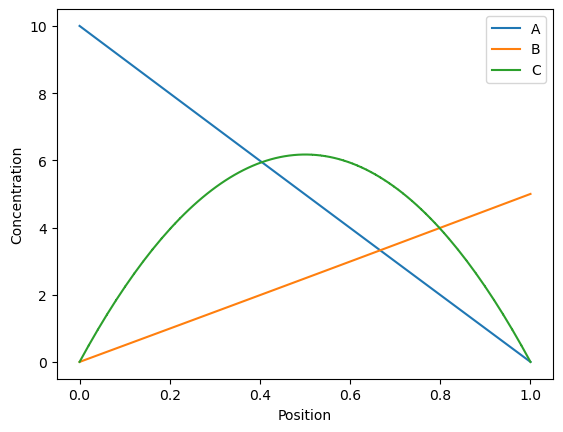

In [4]:
import matplotlib.pyplot as plt


def plot_profile(species, **kwargs):
    index = my_model.species.index(species)
    V0, dofs = my_model.function_space.sub(index).collapse()
    coords = V0.tabulate_dof_coordinates()[:, 0]
    sort_coords = np.argsort(coords)
    c = my_model.u.x.array[dofs][sort_coords]
    x = coords[sort_coords]
    return plt.plot(x, c, **kwargs)


for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

As expected, the concentration of Species C is highest where the product $c_A c_B$ is highest.

## Two-way reaction

The previous example can be very easily extended to a two-way reaction:

```{math}
\ce{A + B <-->[k][p] C}
```

The governing equations for this problem are:

\begin{align}
    \frac{\partial c_A}{\partial t} &= \nabla \cdot (D \nabla c_A) - k c_A c_B + p c_C\\
    \frac{\partial c_B}{\partial t} &= \nabla \cdot (D \nabla c_B) -k c_A c_B+ p c_C\\
    \frac{\partial c_C}{\partial t} &= k c_A c_B - p c_C
\end{align}

In [5]:
my_model = F.HydrogenTransportProblem()

A = F.Species("A")
B = F.Species("B")
C = F.Species("C", mobile=False)
my_model.species = [A, B, C]

my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

# assumes the same diffusivity for all species
material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[A, B],
        product=[C],
        k_0=0.01,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    )
]

my_model.boundary_conditions = [
    # A BCs
    F.FixedConcentrationBC(left_surf, value=10, species=A),
    F.FixedConcentrationBC(right_surf, value=0, species=A),
    # B BCs
    F.FixedConcentrationBC(left_surf, value=0, species=B),
    F.FixedConcentrationBC(right_surf, value=5, species=B),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

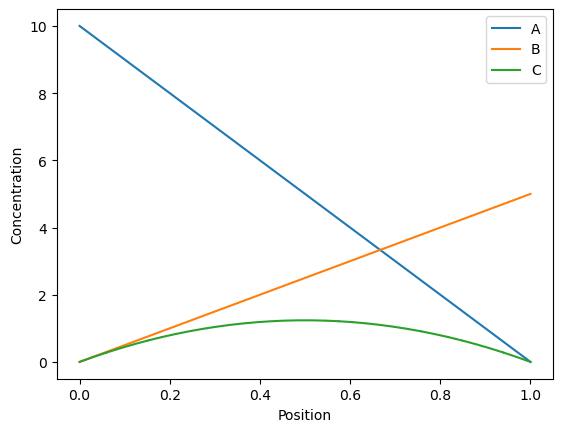

In [6]:
for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## Chain reaction

Here we consider a reaction scheme where mobile species A and B react to form species C (immobile).
Species C then reacts *on its own* to form species D.

```{math}
\ce{A + B <-->[k_1][p_1] C}
```

```{math}
\ce{C ->[k_2] D}
```

The governing equations of this system are:

\begin{align}
    \frac{\partial c_A}{\partial t} &= \nabla \cdot (D \nabla c_A) - k_1 c_A c_B + p_1 c_C\\
    \frac{\partial c_B}{\partial t} &= \nabla \cdot (D \nabla c_B) -k_1 c_A c_B+ p_1 c_C\\
    \frac{\partial c_C}{\partial t} &= k_1 c_A c_B - p_1 c_C - k_2 c_C\\
    \frac{\partial c_D}{\partial t} &= \nabla \cdot (D \nabla c_D) + k_2 c_C\\
\end{align}

To implement this in a FESTIM model, one simply has to add both reactions with two ``Reaction`` objects.

In [7]:
my_model = F.HydrogenTransportProblem()

A = F.Species("A")
B = F.Species("B")
C = F.Species("C", mobile=False)
D = F.Species("D")
my_model.species = [A, B, C, D]

my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

# assumes the same diffusivity for all species
material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[A, B],
        product=[C],
        k_0=0.01,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    ),
    F.Reaction(
        reactant=[C],
        product=[D],
        k_0=0.2,
        E_k=0,
        p_0=0,
        E_p=0,
        volume=vol,
    ),
]

my_model.boundary_conditions = [
    # A BCs
    F.FixedConcentrationBC(left_surf, value=10, species=A),
    F.FixedConcentrationBC(right_surf, value=0, species=A),
    # B BCs
    F.FixedConcentrationBC(left_surf, value=0, species=B),
    F.FixedConcentrationBC(right_surf, value=5, species=B),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

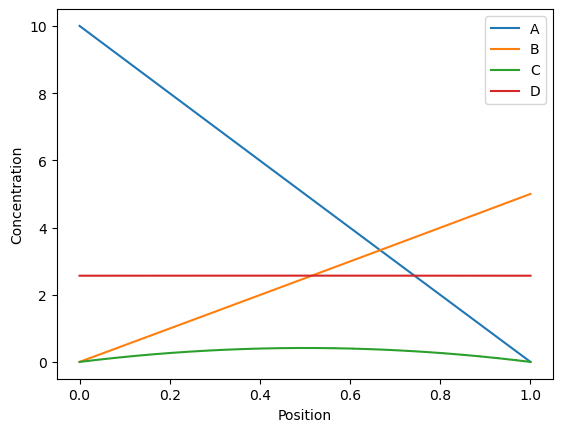

In [8]:
for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

After 5 s, we can see that the concentration of D is fairly flat. This is because D is mobile, but the boundary conditions for this species are no-flux conditions. Species D will therefore diffuse but won't "escape" the domain.

## Trapping


Hydrogen trapping can be represented as a reaction too. Here we consider mobile hydrogen ($\mathrm{H}$) reacting with an empty trap ($[\ ]$) to form trapped hydrogen ($\mathrm{[H]}$):

```{math}
\ce{H + [ ] <-->[k][p] [H]}
```


The governing equations for this problem are:

\begin{align}
    \frac{\partial c_\mathrm{m}}{\partial t} &= \nabla \cdot (D \nabla c_\mathrm{m}) - k c_\mathrm{m} n_\mathrm{empty} + p c_\mathrm{t}\\
    \frac{\partial n_\mathrm{empty}}{\partial t} &= -k c_\mathrm{m} n_\mathrm{empty} + p c_\mathrm{t}\\
    \frac{\partial c_\mathrm{t}}{\partial t} &= k c_\mathrm{m} n_\mathrm{empty} - p c_\mathrm{t}
\end{align}


Following what was done in the [Species](species.ipynb) tutorial, we will show that empty traps can be represented either as an explicit or implicit species.

### Explicit trapping sites

Here, we treat the empty trapping sites as an explicit species with an initial concentration.

In [9]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

mobile_H = F.Species("H")
trapped_H = F.Species("H_trapped", mobile=False)
empty_traps = F.Species("empty_traps", mobile=False)

my_model.species = [mobile_H, trapped_H, empty_traps]

my_model.initial_conditions = [F.InitialCondition(value=2, species=empty_traps)]

```{note}
Here we set the empty traps as immobile, but they could diffuse in the material too by setting ``mobile=True``.
```

In [10]:
left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[mobile_H, empty_traps],
        product=[trapped_H],
        k_0=0.01,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    ),
]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=mobile_H),
    F.FixedConcentrationBC(right_surf, value=0, species=mobile_H),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

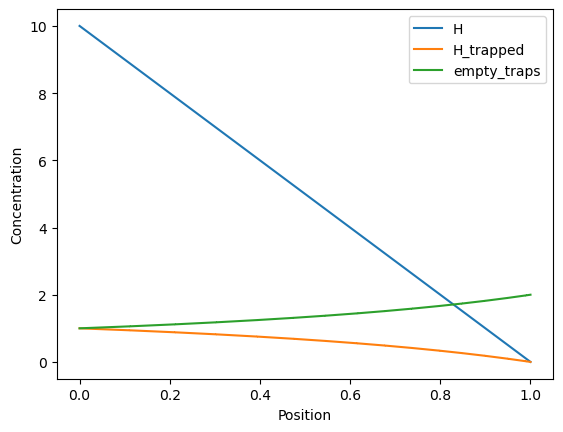

In [11]:
for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

### Implicit trapping sites

As showed in the [Species](species.ipynb) tutorial, in this case, empty traps can be defined as an implicit species, and their concentration is defined as:

$$
n_\mathrm{empty} = n_\mathrm{total} - c_\mathrm{t}
$$

In [12]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

mobile_H = F.Species("H")
trapped_H = F.Species("H_trapped", mobile=False)
empty_traps = F.ImplicitSpecies(n=2, others=[trapped_H])

my_model.species = [mobile_H, trapped_H]

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[mobile_H, empty_traps],
        product=[trapped_H],
        k_0=0.01,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    ),
]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=mobile_H),
    F.FixedConcentrationBC(right_surf, value=0, species=mobile_H),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

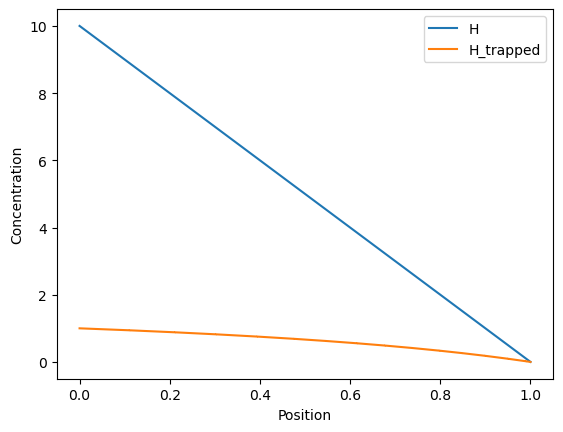

In [13]:
for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

### Convenience class for trapping

For simple cases (ie. one mobile species, one hydrogen per trap), FESTIM has a convenience class ``Trap`` to simplify the inputs.

With this class, all that is needed is defining the trapping rates, the mobile species, the total number of traps. It provides a slightly more compact way of defining traps, at the cost of flexibility.

In [14]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

material = F.Material(D_0=1, E_D=0)
left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)
vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)
my_model.subdomains = [vol, left_surf, right_surf]

mobile_H = F.Species("H")
my_model.species = [mobile_H]

my_model.traps = [
    F.Trap(
        mobile_species=mobile_H,
        k_0=0.01,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
        n=2,  # number of traps
        name="Trap1",
    )
]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=mobile_H),
    F.FixedConcentrationBC(right_surf, value=0, species=mobile_H),
]

my_model.temperature = 300
my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)
my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

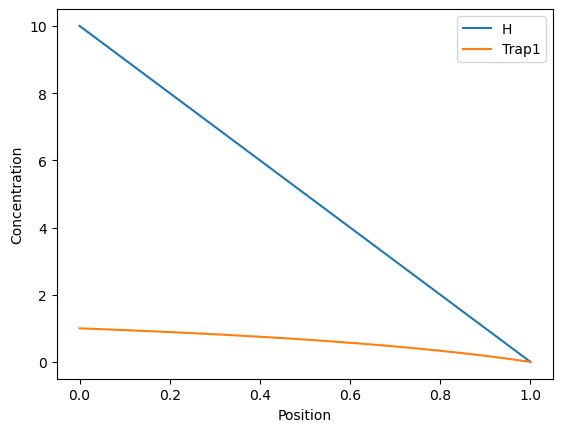

In [15]:
for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

### Multi-occupancy trapping

```{math}
\ce{H + [ ] <-->[k][p] [1H]}
```

```{math}
\ce{H + [H] <-->[k][p] [1H]}
```

```{math}
\ce{H + [2H] <-->[k][p] [3H]}
```

In [16]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))


mobile_H = F.Species("H")
trapped_1H = F.Species("1H_trapped", mobile=False)
trapped_2H = F.Species("2H_trapped", mobile=False)
trapped_3H = F.Species("3H_trapped", mobile=False)
empty_traps = F.ImplicitSpecies(n=2, others=[trapped_1H, trapped_2H, trapped_3H])

my_model.species = [mobile_H, trapped_1H, trapped_2H, trapped_3H]

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[mobile_H, empty_traps],
        product=[trapped_1H],
        k_0=0.01,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    ),
    F.Reaction(
        reactant=[mobile_H, trapped_1H],
        product=[trapped_2H],
        k_0=0.02,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    ),
    F.Reaction(
        reactant=[mobile_H, trapped_2H],
        product=[trapped_3H],
        k_0=0.03,
        E_k=0,
        p_0=0.1,
        E_p=0,
        volume=vol,
    ),
]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=mobile_H),
    F.FixedConcentrationBC(right_surf, value=0, species=mobile_H),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

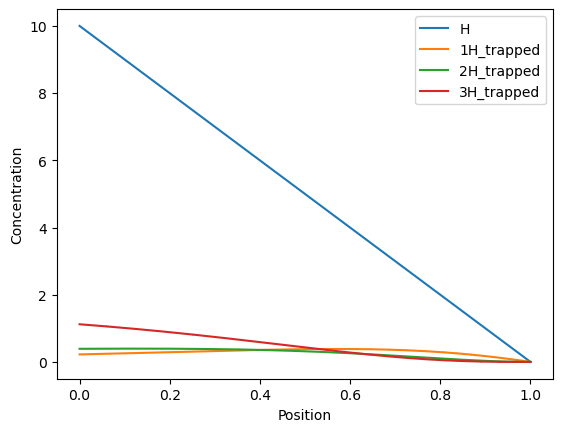

In [17]:
for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## Two species, one trap

```{math}
\ce{H + [] <-->[k][p] [H]}
```

```{math}
\ce{D + [] <-->[k][p] [D]}
```

In [18]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))


mobile_H = F.Species("H")
mobile_T = F.Species("T")
trapped_H = F.Species("H_trapped", mobile=False)
trapped_T = F.Species("T_trapped", mobile=False)
empty_traps = F.ImplicitSpecies(n=2, others=[trapped_H, trapped_T])

my_model.species = [mobile_H, mobile_T, trapped_H, trapped_T]


left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[mobile_H, empty_traps],
        product=[trapped_H],
        k_0=0.005,
        E_k=0,
        p_0=0.005,
        E_p=0,
        volume=vol,
    ),
    F.Reaction(
        reactant=[mobile_T, empty_traps],
        product=[trapped_T],
        k_0=0.005,
        E_k=0,
        p_0=0.005,
        E_p=0,
        volume=vol,
    ),
]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=mobile_H),
    F.FixedConcentrationBC(right_surf, value=0, species=mobile_H),
    F.FixedConcentrationBC(left_surf, value=0, species=mobile_T),
    F.FixedConcentrationBC(right_surf, value=5, species=mobile_T),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=10)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

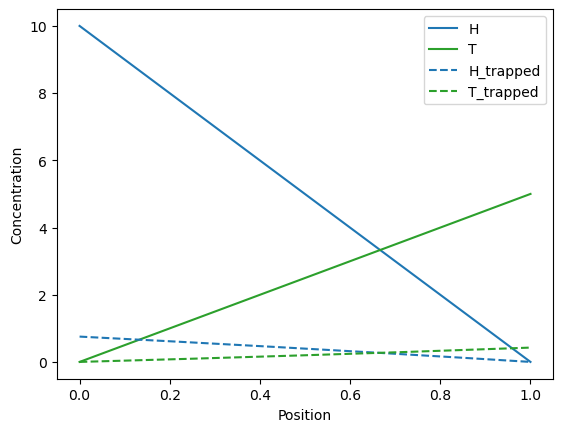

In [19]:
for species in my_model.species:
    if "T" in species.name:
        color = "tab:green"
    else:
        color = "tab:blue"
    if "trapped" in species.name:
        linestyle = "--"
    else:
        linestyle = "-"
    plot_profile(species, label=species.name, color=color, linestyle=linestyle)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## Isotope swapping

``Reaction`` objects can have multiple products. This is useful to simulate things like isotope swapping where a mobile species reacts with a trapped species, and swap their positions:

```{math}
\ce{H + [T] <-->[k_\mathrm{swap}][k_\mathrm{swap}] T + [H]}
```

In this example we consider the above reaction, with an initial condition for the trapped T concentration and mobile H diffusing in the domain, slowly swapping trapped T.

In [20]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))


mobile_H = F.Species("H")
mobile_T = F.Species("T")
trapped_H = F.Species("H_trapped", mobile=False)
trapped_T = F.Species("T_trapped", mobile=False)

my_model.species = [mobile_H, mobile_T, trapped_H, trapped_T]

my_model.initial_conditions = [
    F.InitialCondition(value=2, species=trapped_T),
]

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(
        reactant=[mobile_H, trapped_T],
        product=[mobile_T, trapped_H],
        k_0=0.005,
        E_k=0,
        p_0=0.005,
        E_p=0,
        volume=vol,
    ),
]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=mobile_H),
    F.FixedConcentrationBC(right_surf, value=0, species=mobile_H),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=10)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

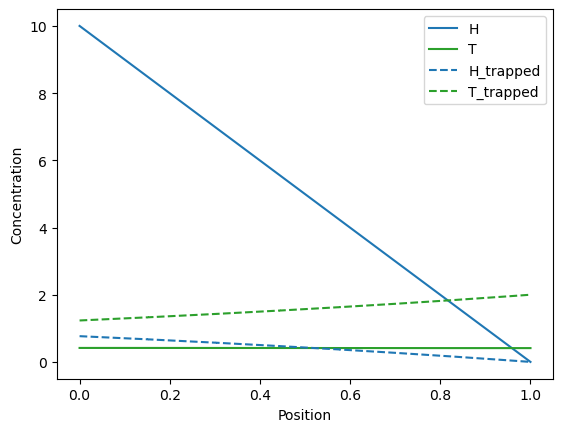

In [21]:
for species in my_model.species:
    if "T" in species.name:
        color = "tab:green"
    else:
        color = "tab:blue"
    if "trapped" in species.name:
        linestyle = "--"
    else:
        linestyle = "-"
    plot_profile(species, label=species.name, color=color, linestyle=linestyle)

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## Anihilation

``Reaction`` objects can also have no products at all, simulating anhiliation reactions.

### Radioactive decay

When dealing with radioactive species, this type of reaction can be used to simulate radioactive decay. The rate of the reaction being equal to the decay constant.

Here we consider a species A decaying with a decay constant $\lambda$.


```{math}
\ce{A ->[\lambda] \emptyset}
```

In [22]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

A = F.Species("A")

my_model.species = [A]

my_model.initial_conditions = [F.InitialCondition(value=1, species=A)]

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(reactant=[A], k_0=1, E_k=0, volume=vol),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=1)

my_model.settings.stepsize = F.Stepsize(1)

my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

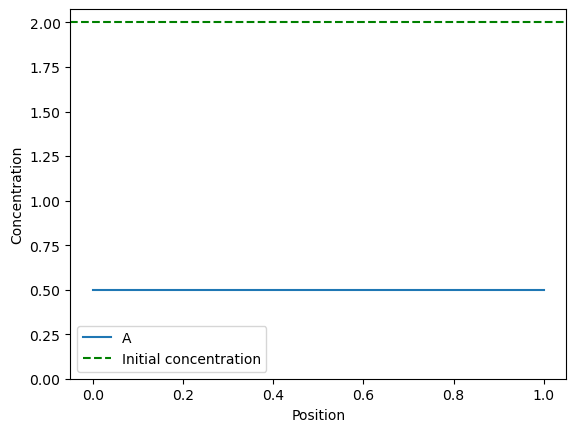

In [23]:
x = my_model.mesh.mesh.geometry.x[:, 0]
c = A.solution.x.array[:]

plt.plot(x, c, label=A.name)
plt.axhline(2, linestyle="--", color="green", label="Initial concentration")

plt.xlabel("Position")
plt.ylabel("Concentration")
plt.ylim(bottom=0)
plt.legend()
plt.show()

### Vacancy-interstitial anihilation

Another use case of this type of reaction is metal interstitial atoms recombining with vacancies (both forming a Frenkel pair) and anihilate.

```{math}
\ce{I + V ->[k] \emptyset}
```

In this example, we define two mobile species I and V, both diffusing from one side of the 1D domain and anihilating.

In [24]:
my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

I = F.Species("I")
V = F.Species("V")

my_model.species = [I, V]

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.reactions = [
    F.Reaction(reactant=[I, V], k_0=1000, E_k=0, volume=vol),
]
my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=10, species=I),
    F.FixedConcentrationBC(right_surf, value=0, species=I),
    F.FixedConcentrationBC(left_surf, value=0, species=V),
    F.FixedConcentrationBC(right_surf, value=5, species=V),
]
my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, transient=False)

my_model.initialise()
my_model.run()

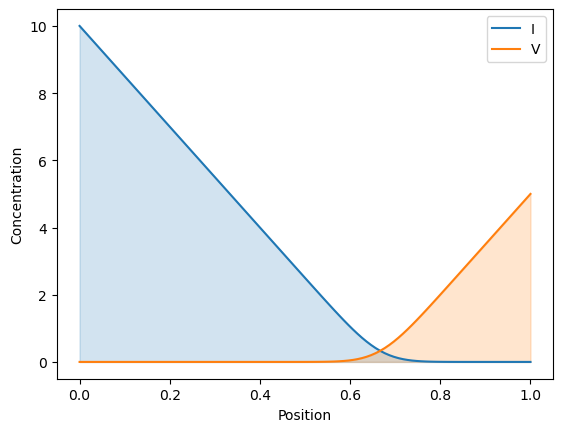

In [25]:
for species in my_model.species:
    l, = plot_profile(species, label=species.name)
    plt.fill_between(
        l.get_data()[0],
        0,
        l.get_data()[1],
        alpha=0.2,
        color=l.get_color(),
    )


plt.xlabel("Position")
plt.ylabel("Concentration")
plt.legend()
plt.show()